In [11]:
%%writefile Dockerfile

FROM python:latest

RUN mkdir /injector

COPY injector/main.py /injector/

RUN pip install -q --force-reinstall \
    nats-py \
    numpy \ 
    pillow \
    pandas \
    minio \
    requests \
    tqdm

WORKDIR /injector
CMD python3 /injector/main.py

Overwriting Dockerfile


In [12]:
%%bash
docker build -f Dockerfile . -t landerlini/sosc-injector:v0.1

#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 292B done
#1 DONE 0.2s

#2 [internal] load .dockerignore
#2 transferring context: 2B done
#2 DONE 0.2s

#3 [internal] load metadata for docker.io/library/python:latest
#3 DONE 0.0s

#4 [1/5] FROM docker.io/library/python:latest
#4 CACHED

#5 [internal] load build context
#5 transferring context: 8.41kB done
#5 DONE 0.4s

#6 [2/5] RUN mkdir /injector
#6 DONE 1.7s

#7 [3/5] COPY injector/main.py /injector/
#7 DONE 0.7s

#8 [4/5] RUN pip install -q --force-reinstall     nats-py     numpy     pillow     pandas     minio     requests     tqdm
#8 24.87 WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv
#8 DONE 29.7s

#9 [5/5] WORKDIR /injector
#9 DONE 1.0s

#10 exporting to image
#10 expor

In [14]:
%%writefile docker-compose.yaml

services:
  nats_inject:
    image: landerlini/sosc-injector:v0.1
    volumes:
      - ${PWD}/injector:/injector.dev
      - /tmp:/tmp
    command: |
      python3 /injector.dev/main.py

    network_mode: host
    
    environment:
      MINIO_URL: minio:9000
      MINIO_USER: 3TVdK/YmR1nc!pDpS?doTn8qT0gNiFO4cj8Vhdo8
      MINIO_ACCESS_KEY: DgloAlKQz55EVogiqOd6KvCgtTxVs1njs-TvheufwIt8Cjw9kNtBz73n2R6AY9rl
      HTTP_DATA_SOURCE: https://pandora.infn.it/public/16cf05/dl/cygno-sim.tar
      EVENTS_PER_HOUR: 1800 

  nats_server:
    image: nats:latest 
    ports:
      - 14222:4222
      - 18222:8222



Overwriting docker-compose.yaml


In [15]:
%%bash
docker-compose up -d --build

 Container nats_injector-nats_server-1  Running
 Container nats_injector-nats_inject-1  Recreate
 Container nats_injector-nats_inject-1  Recreated
 Container nats_injector-nats_inject-1  Starting
 Container nats_injector-nats_inject-1  Started


Nats injector ready.
Target bucket exists.
Found 13404 in ./original/
Local dataset is now available.


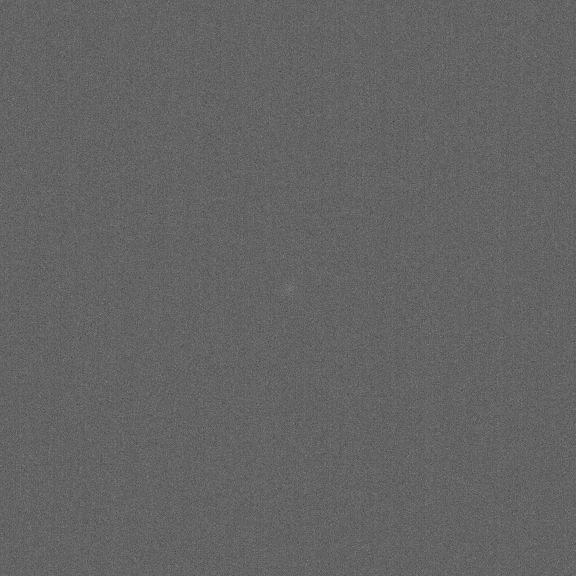

Event cygno-8a5dd63738189018c7fad9a7ce5eee71.jpg uploaded to cygno-daq and submitted to 'daq/data'


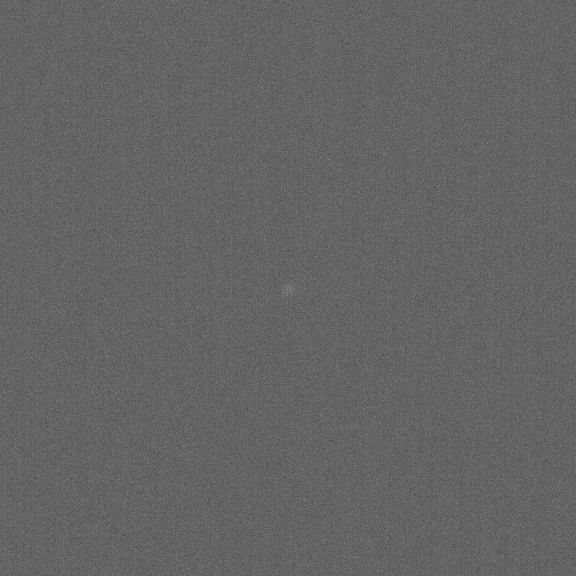

Event cygno-9c618f52e4bdeea5171f109449923a14.jpg uploaded to cygno-daq and submitted to 'daq/data'


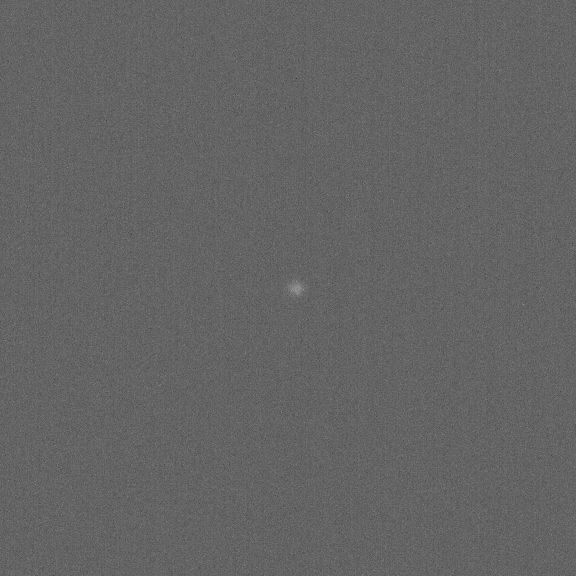

Event cygno-72b2ce75ca60a3bb20f3aa4fb5712c9e.jpg uploaded to cygno-daq and submitted to 'daq/data'


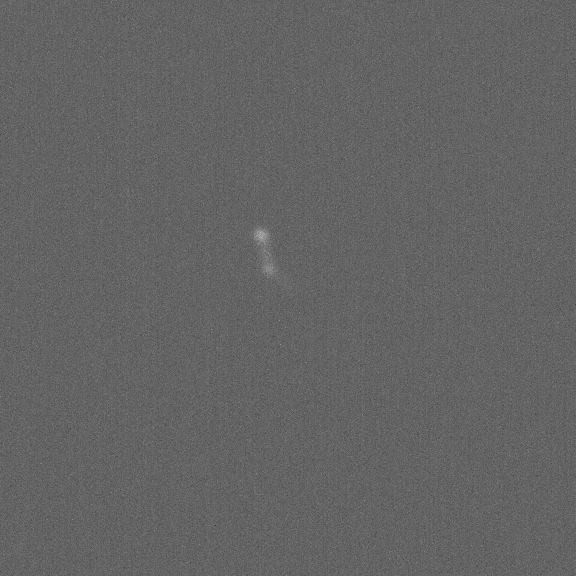

Event cygno-b2e27b10dcbc156c03c79ba1b8717425.jpg uploaded to cygno-daq and submitted to 'daq/data'


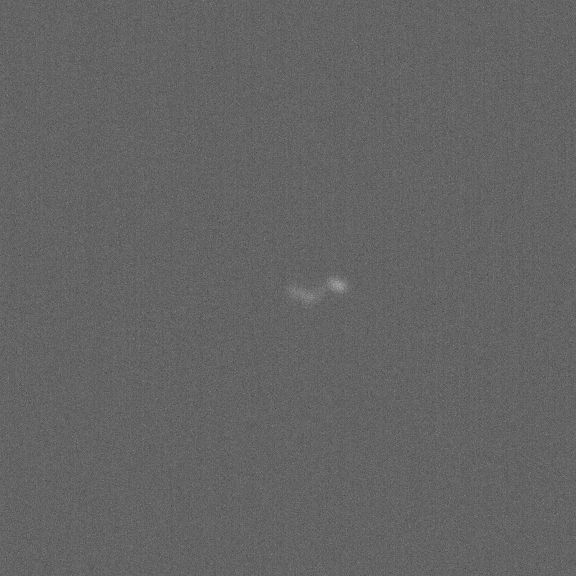

Event cygno-0cf7b88ec8f04acdaf5739af8b8d7bf8.jpg uploaded to cygno-daq and submitted to 'daq/data'


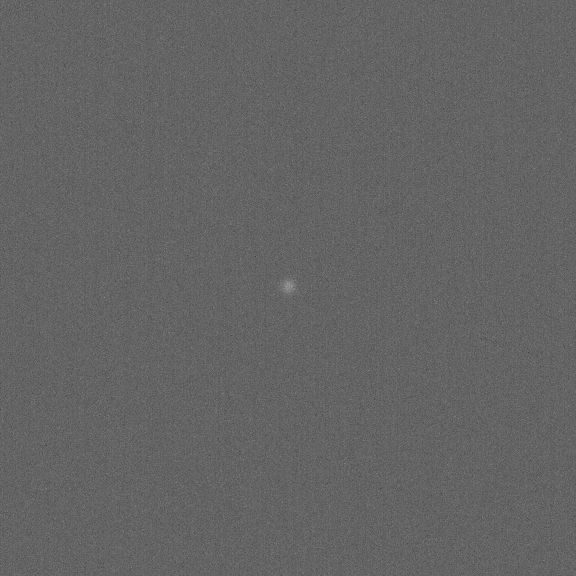

In [16]:
from pynats import NATSClient
import json
import requests
from io import BytesIO
from PIL import Image

def download_image(msg):
    contents = json.loads(str(msg.payload, 'utf-8'))
    if 'url' in contents:
        response = requests.get(contents['url'])
        response.raise_for_status()
        cache = BytesIO(response.content)
        img = Image.open(cache)
        display(img)   

with NATSClient("nats://localhost:4222") as client:
    client.subscribe(subject="daq/info", callback=lambda msg: print (str(msg.payload, 'utf-8')))
    client.subscribe(subject="daq/data", callback=download_image)
    
    client.wait(count=15)

In [5]:
%%bash 
docker ps 
docker logs nats_injector-nats_inject-1

CONTAINER ID   IMAGE                       COMMAND                  CREATED         STATUS          PORTS                                                        NAMES
1e3a21abc7bb   nats_injector-nats_inject   "python3 /injector/m…"   2 minutes ago   Up 24 seconds                                                                nats_injector-nats_inject-1
8df8de682cfa   nats:latest                 "/nats-server --conf…"   2 minutes ago   Up 2 minutes    6222/tcp, 0.0.0.0:14222->4222/tcp, 0.0.0.0:18222->8222/tcp   nats_injector-nats_server-1
e80e48d963e2   nats:latest                 "/nats-server --conf…"   2 days ago      Up 2 days       0.0.0.0:4222->4222/tcp, 0.0.0.0:8222->8222/tcp, 6222/tcp     day2-msg-1
356dc2915598   python:latest               "python3 -m http.ser…"   2 days ago      Up 2 days       0.0.0.0:12345->6789/tcp                                      day2-server-1
00da96ea44ae   nats_client:test            "python3 /scripts/to…"   2 days ago      Up 2 days               

2023-09-27 11:49:24 - Server started
2023-09-27 11:49:24 - Using selector: EpollSelector
2023-09-27 11:49:24 - 2023-09-27 11:49:24.441118  Nats injector ready.
2023-09-27 11:49:24 - Starting new HTTP connection (1): minio:9000
2023-09-27 11:49:24 - http://minio:9000 "GET /cygno-daq?location= HTTP/1.1" 200 0
2023-09-27 11:49:24 - http://minio:9000 "HEAD /cygno-daq HTTP/1.1" 200 0
2023-09-27 11:49:24 - 2023-09-27 11:49:24.445502  Target bucket exists.
2023-09-27 11:49:24 - 2023-09-27 11:49:24.476953  Found 13404 in ./original/
2023-09-27 11:49:24 - 2023-09-27 11:49:24.506685  Local dataset is now available.
2023-09-27 11:49:24 - STREAM b'IHDR' 16 13
2023-09-27 11:49:24 - STREAM b'IDAT' 41 65536
2023-09-27 11:49:24 - http://minio:9000 "PUT /cygno-daq/cygno-f0d5a3bfd5143f5bbe3862f2349c82fc.jpg HTTP/1.1" 200 0
2023-09-27 11:49:25 - 2023-09-27 11:49:25.063425  Event cygno-f0d5a3bfd5143f5bbe3862f2349c82fc.jpg uploaded to cygno-daq and submitted to 'daq/data'
2023-09-27 11:49:25 - STREAM b'IHD

In [6]:
#!docker-compose down

In [8]:
!docker restart nats_injector-nats_inject-1
!docker container ls

nats_injector-nats_inject-1
CONTAINER ID   IMAGE                       COMMAND                  CREATED         STATUS                  PORTS                                                        NAMES
1e3a21abc7bb   nats_injector-nats_inject   "python3 /injector/m…"   6 minutes ago   Up Less than a second                                                                nats_injector-nats_inject-1
8df8de682cfa   nats:latest                 "/nats-server --conf…"   6 minutes ago   Up 6 minutes            6222/tcp, 0.0.0.0:14222->4222/tcp, 0.0.0.0:18222->8222/tcp   nats_injector-nats_server-1
e80e48d963e2   nats:latest                 "/nats-server --conf…"   2 days ago      Up 2 days               0.0.0.0:4222->4222/tcp, 0.0.0.0:8222->8222/tcp, 6222/tcp     day2-msg-1
356dc2915598   python:latest               "python3 -m http.ser…"   2 days ago      Up 2 days               0.0.0.0:12345->6789/tcp                                      day2-server-1
00da96ea44ae   nats_client:test         